In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("talk")

colors = sns.color_palette()

In [2]:
def B(t, params):
    """
    Calculate the magnetic field at time t.
    """

    h = params["h"]
    B_0 = params["B_0"]
    OMEGA_0 = params["OMEGA_0"]
    phi = params["phi"] 
    
    # Calculate the magnetic field at time t
    return np.array([
        h * np.cos(OMEGA_0 * t + phi), 
        -h * np.sin(OMEGA_0 * t + phi), 
        B_0
    ])


def expB(t, B):
    """
    Calculate the exponential of the magnetic field for the product formula 
    at time t using the analytical expression.
    """

    Bx, By, Bz = B
    Omega = np.sqrt(Bx**2 + By**2 + Bz**2)

    # Calculate the exponential using its analytical expression
    return np.array([
        [
            (Bx**2 + (By**2 + Bz**2) * np.cos(Omega * t)) 
            / Omega**2,
            (Bx * By * (1 - np.cos(Omega * t)) + Bz * Omega * np.sin(Omega * t))
            / Omega**2,
            (Bx * Bz * (1 - np.cos(Omega * t)) - By * Omega * np.sin(Omega * t))
            / Omega**2,
        ],
        [
            (Bx * By * (1 - np.cos(Omega * t)) - Bz * Omega * np.sin(Omega * t))
            / Omega**2,
            (By**2 + (Bx**2 + Bz**2) * np.cos(Omega * t)) 
            / Omega**2,
            (By * Bz * (1 - np.cos(Omega * t)) + Bx * Omega * np.sin(Omega * t))
            / Omega**2,
        ],
        [
            (Bx * Bz * (1 - np.cos(Omega * t)) + By * Omega * np.sin(Omega * t))
            / Omega**2,
            (By * Bz * (1 - np.cos(Omega * t)) - Bx * Omega * np.sin(Omega * t))
            / Omega**2,
            (Bz**2 + (Bx**2 + By**2) * np.cos(Omega * t)) 
            / Omega**2,
        ],
    ])


def simulate(M0, ts, params):
    """
    Simulate the rotation of magnetization by solving the Bloch equation 
    using a second order product formula.
    """
    
    tau = params["TAU"]
    gamma = params["GAMMA"]
    T1_recipr = params["T1_recipr"]
    T2_recipr = params["T2_recipr"]

    # Define the diagonal elements of the relaxation matrix
    C = - np.array([
    T2_recipr / gamma, 
    T2_recipr / gamma, 
    T1_recipr / gamma
    ])

    # Initialize the magnetization matrix to store the magnetization at each time point
    Ms = np.zeros((ts.shape[0], M0.shape[0]))
    Ms[0, :] = M0
    
    # Loop over each time step
    for i, t in enumerate(ts[1:], 1):

        # Multiply the previous magnetization by the relaxation matrix exponential
        Ms[i, :] = np.exp(tau * gamma * C / 2) * Ms[i - 1, :]

        # Multiply the magnetization by the rotation matrix
        Ms[i, :] = expB(tau, B(t + tau / 2, params)) @ Ms[i, :]

        # Multiply the magnetization by the relaxation matrix exponential
        Ms[i, :] = np.exp(tau * gamma * C / 2) * Ms[i, :]

    return Ms

In [3]:
# Definition of the parameters

F_0 = 4
B_0 = 2 * np.pi * F_0  # Magnitude of the main field

F_1 = 1 / 4
h = 2 * np.pi * F_1    # Magnitude of the oscillating field

OMEGA_0 = B_0          # Larmor precession frequency
phi = 0                # Phase of the oscillating field

TAU = F_0 / 10**5      # Time step size
GAMMA = 1              # Gyromagnetic ratio

T1_recipr = 0          # Inverse of the relaxation time T1
T2_recipr = 0          # Inverse of the relaxation time T2

# Store the parameters in a dictionary
params_0 = {
    "F_0": F_0,
    "F_1": F_1,
    "TAU": F_0 / 10**5,

    "B_0": B_0,
    "OMEGA_0": B_0,
    "h": h,
    "phi": phi,

    "GAMMA": GAMMA,
    "T1_recipr": T1_recipr,
    "T2_recipr": T2_recipr
}

# Definition of the time array
ts = np.arange(0, 4 + TAU, TAU)

In [4]:
# Simulate first configuration

M0 = np.array([0, 1, 0])
Ms = simulate(M0, ts, params_0)

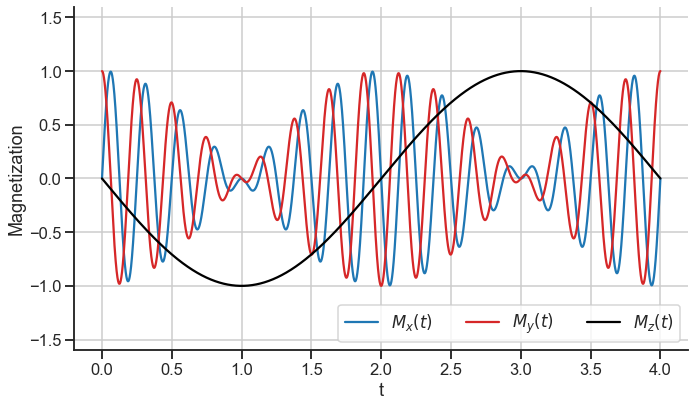

In [5]:
# Plot the magnetization components

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(ts, Ms[:, 0], label=r"$M_x(t)$", color=colors[0])
ax.plot(ts, Ms[:, 1], label=r"$M_y(t)$", color=colors[3])
ax.plot(ts, Ms[:, 2], label=r"$M_z(t)$", color="black")

ax.set_ylabel("Magnetization")
ax.set_xlabel("t")

ax.set_yticks(np.arange(-1.5, 2, 0.5))
ax.set_ylim(-1.6, 1.6)

ax.legend(ncol=3, loc="lower right")
ax.grid()

plt.tight_layout()
sns.despine()
plt.show()

In [6]:
# Varying initial magnetization
M0s = [
    np.array([1, 0, 0]),
    np.array([0, 1, 0]),
    np.array([0, 0, 1]),
    np.array([1, 0, 1]),
]

# Varying relaxation time
T1_reciprs = [0, 1]
T2_reciprs = [0, 1]

# Varying phase of the oscillating field
phis = {
    "0": 0,
    "pi_2": np.pi / 2, 
    "pi_4": np.pi / 4,
}

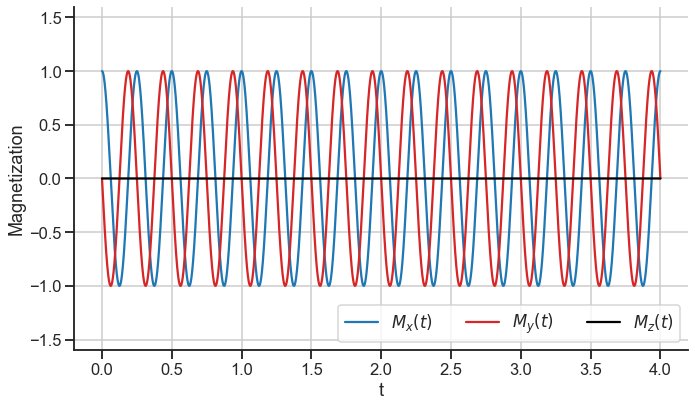

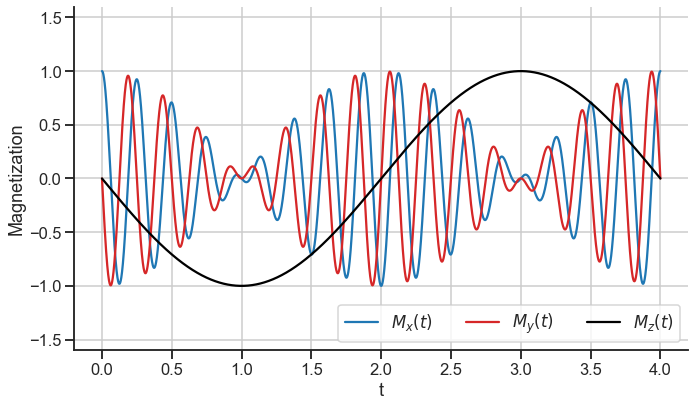

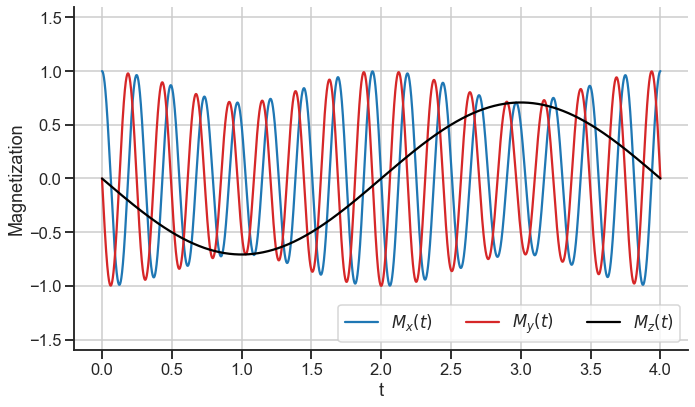

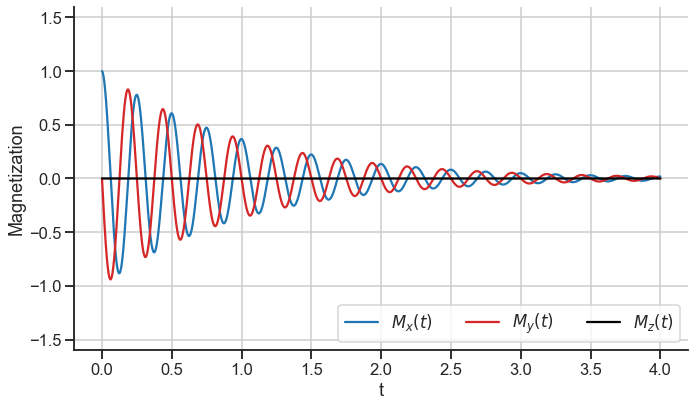

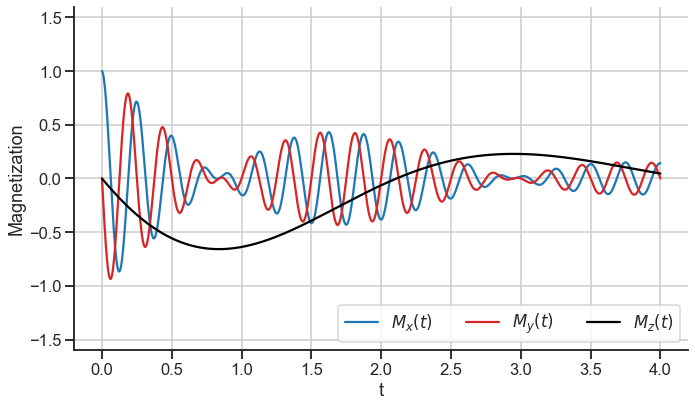

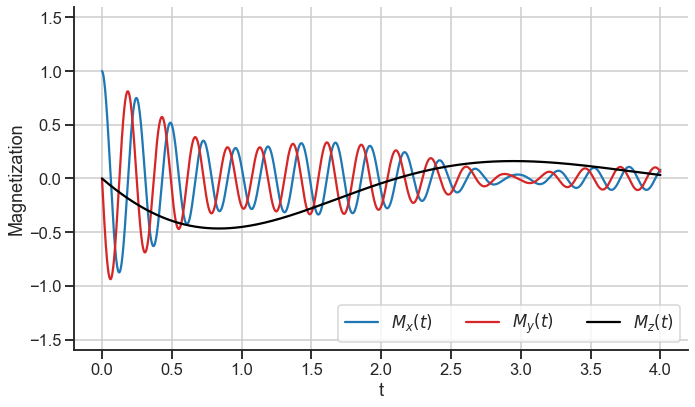

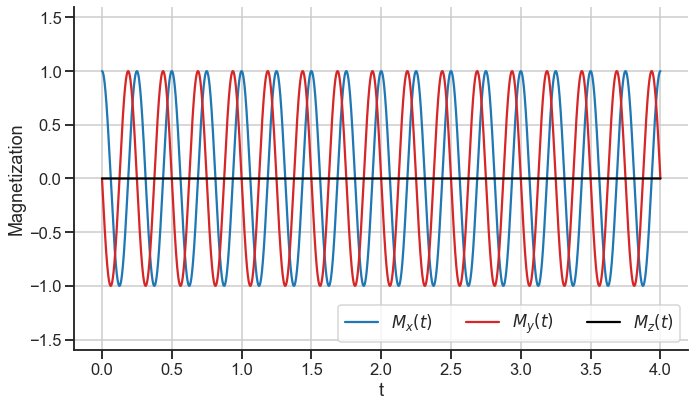

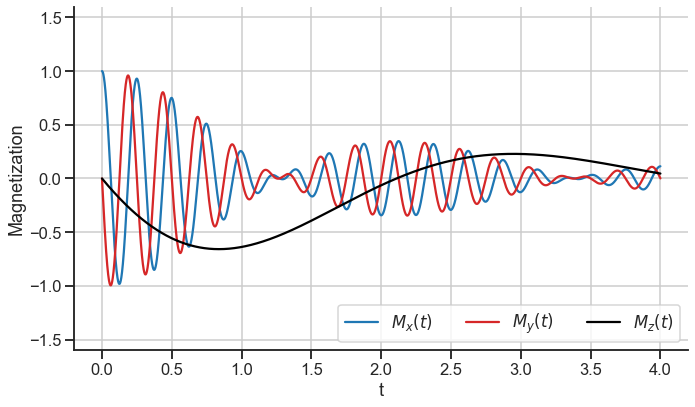

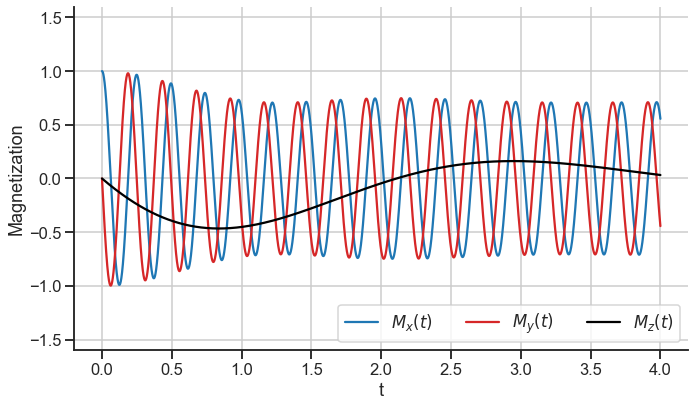

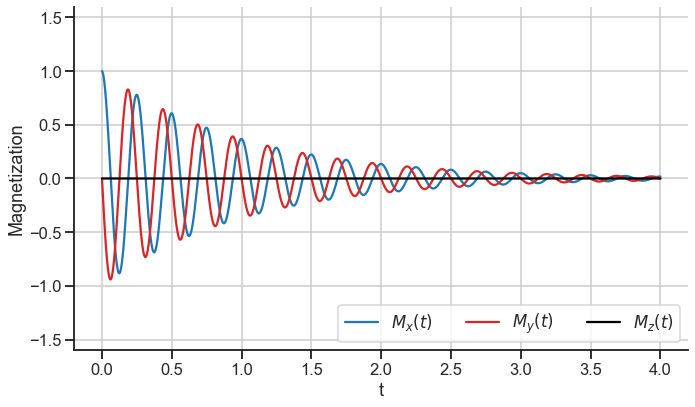

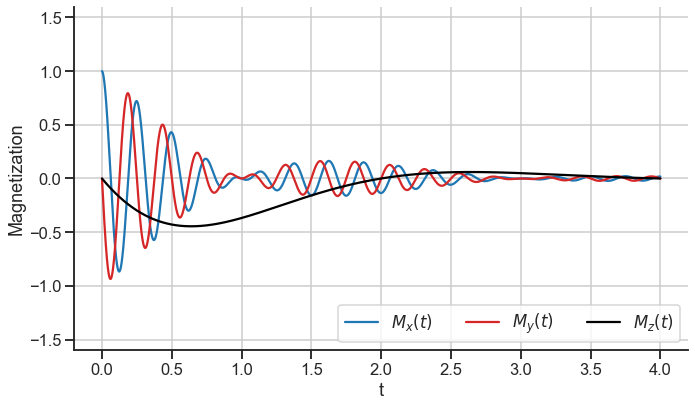

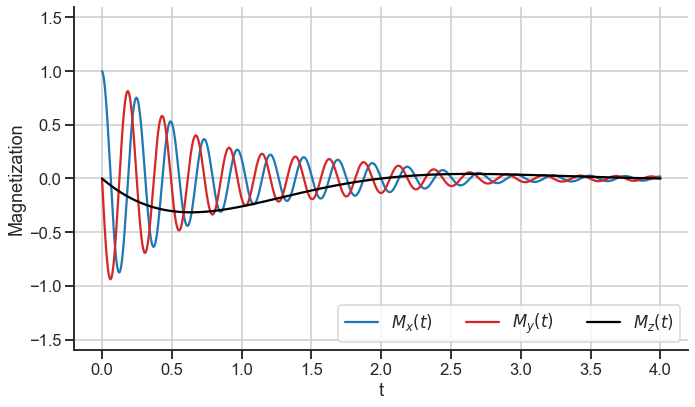

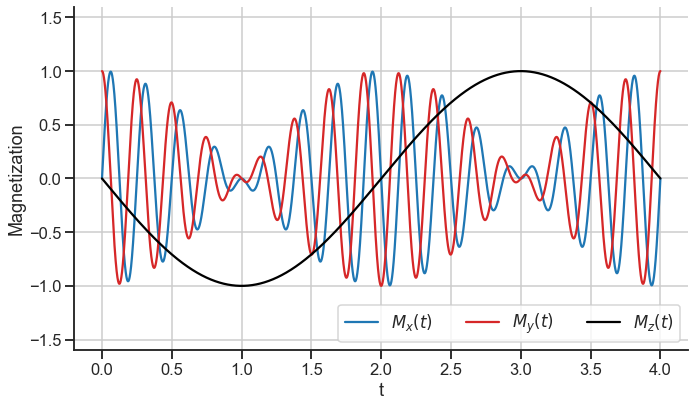

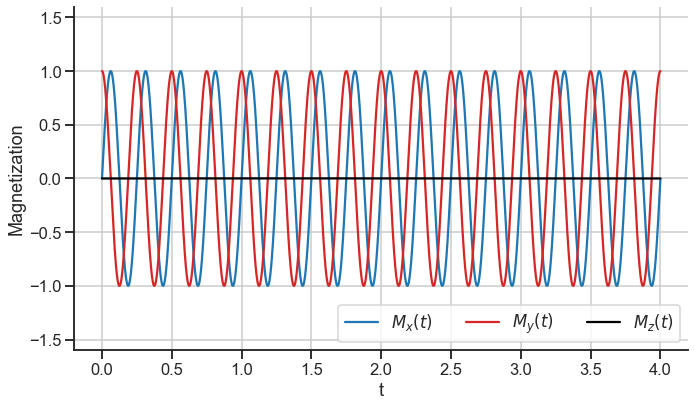

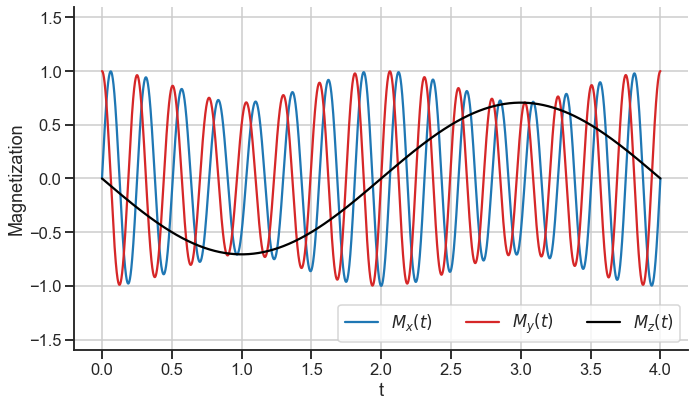

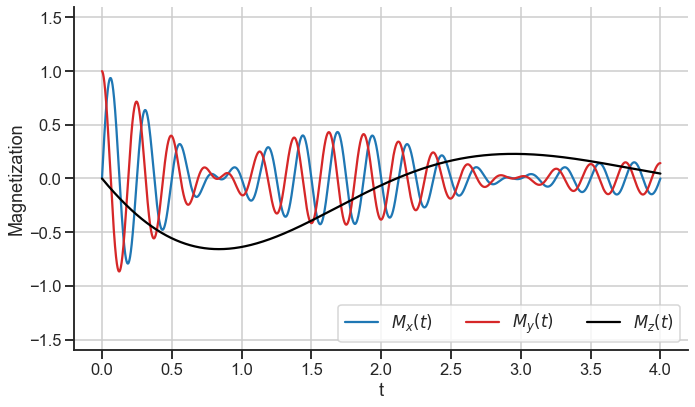

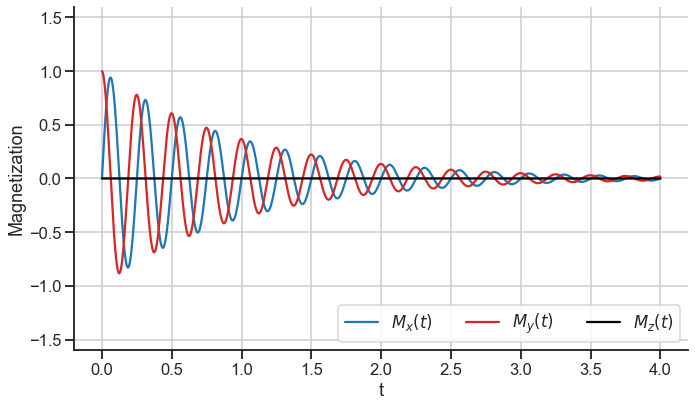

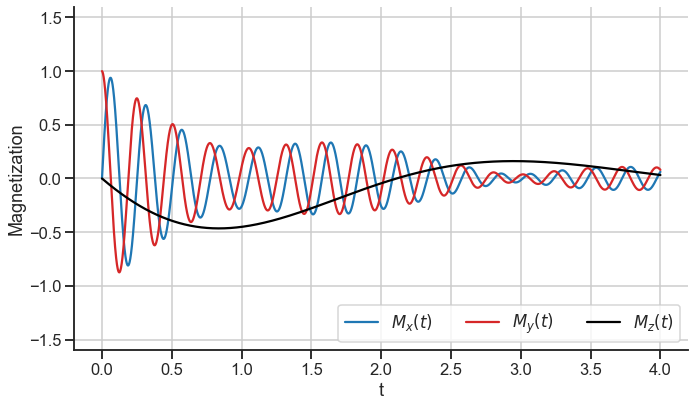

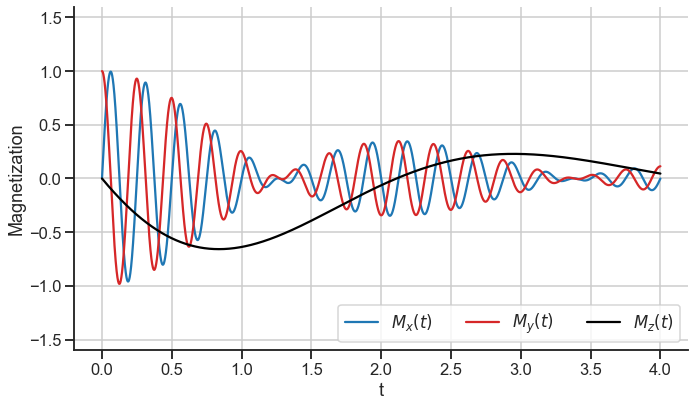

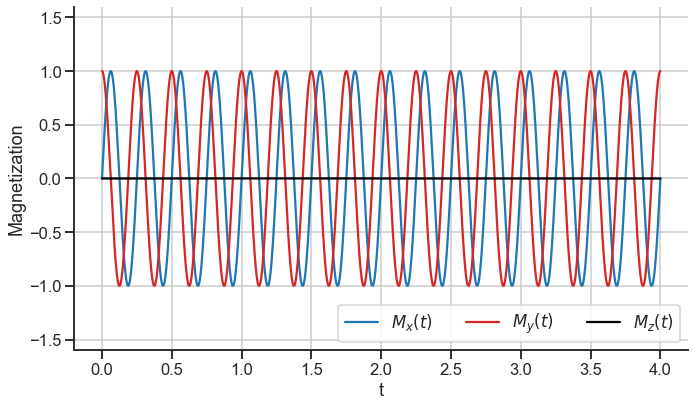

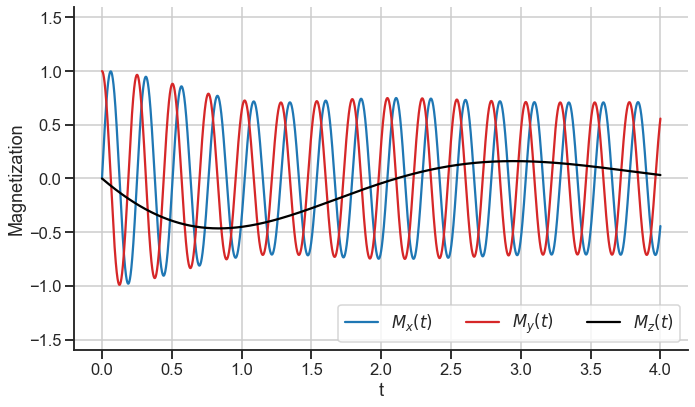

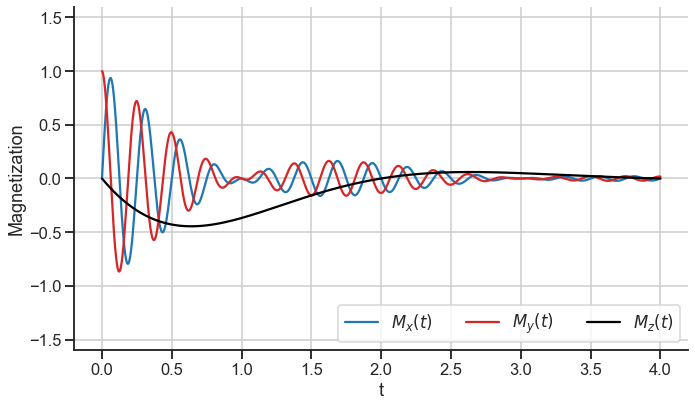

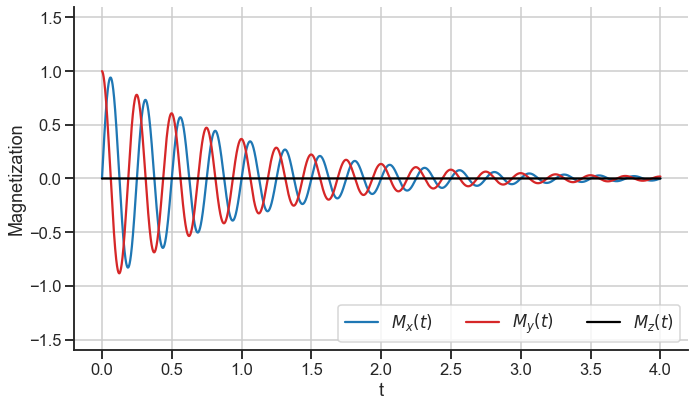

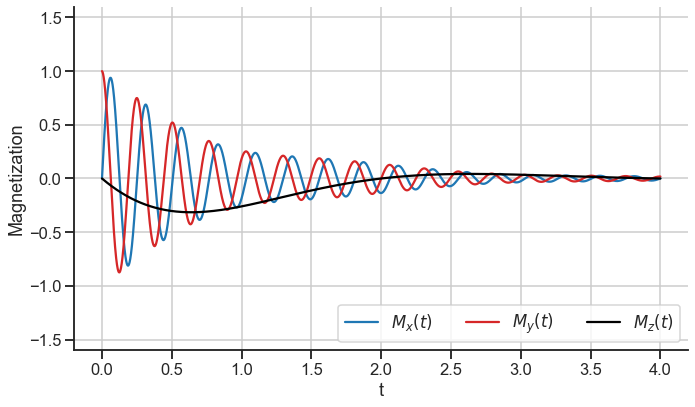

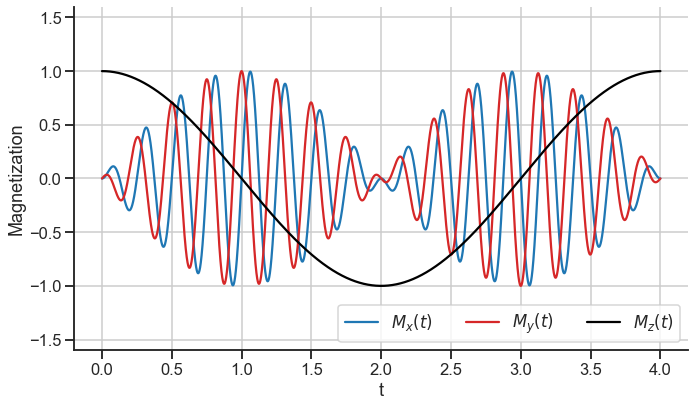

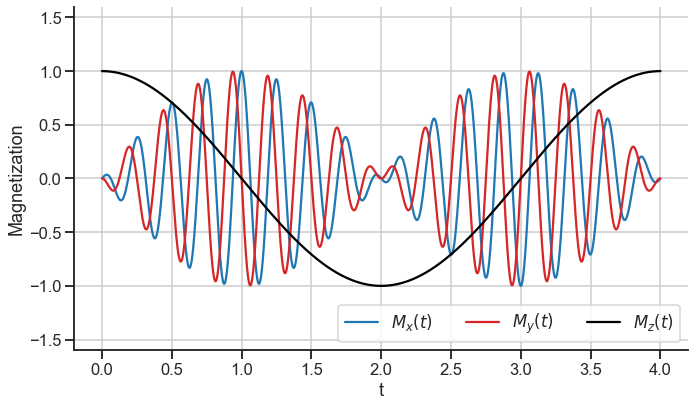

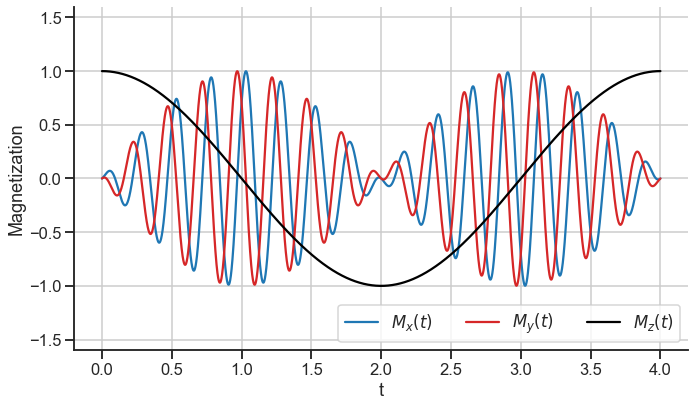

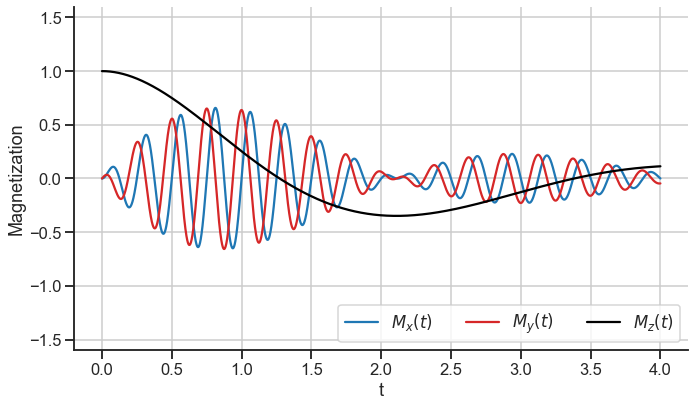

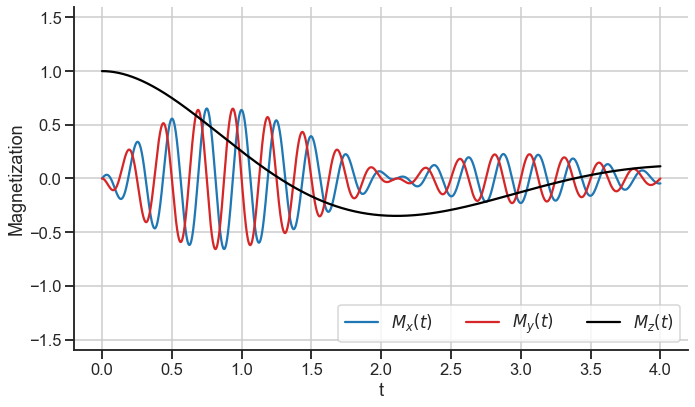

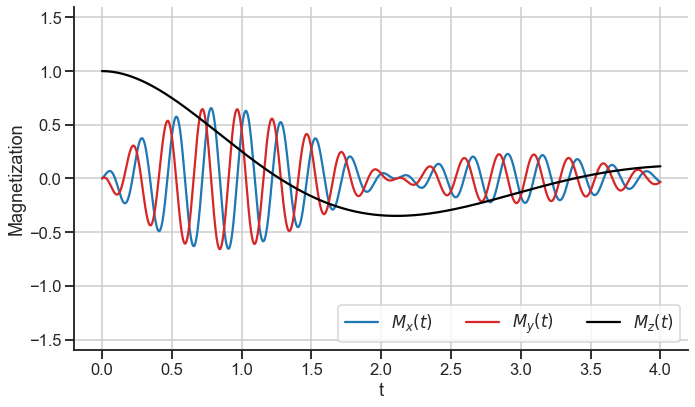

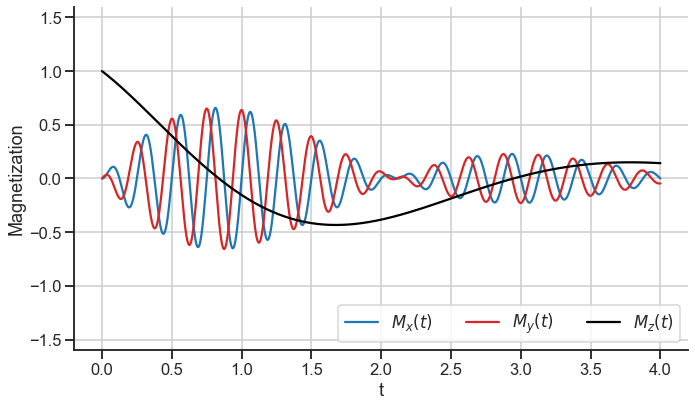

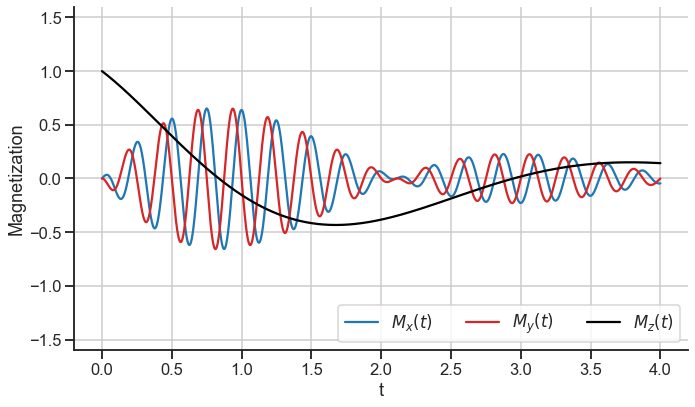

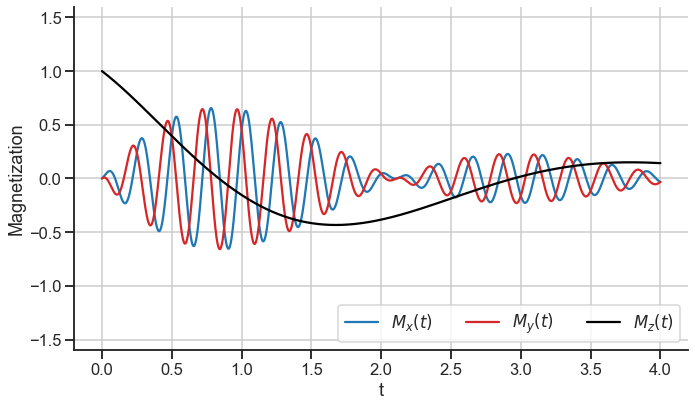

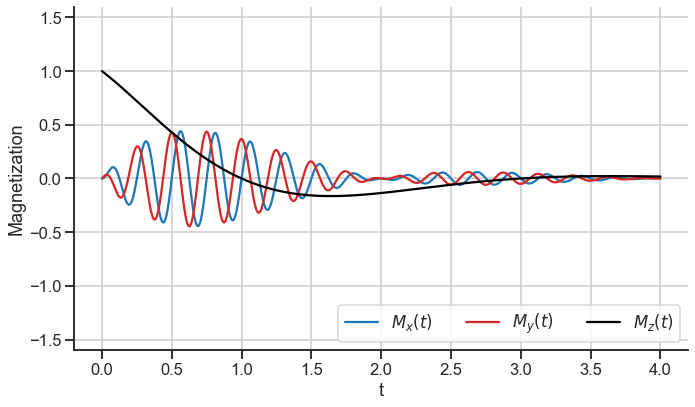

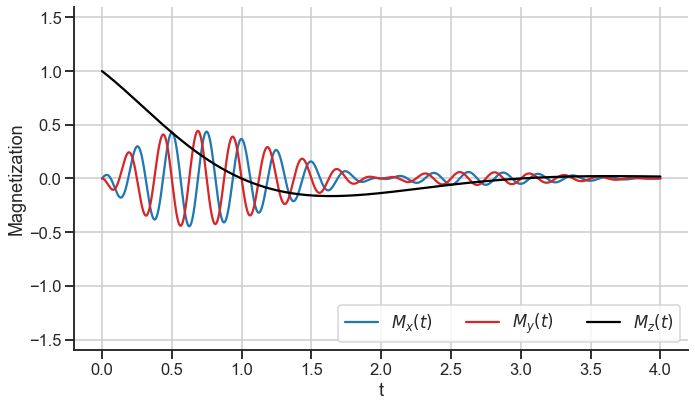

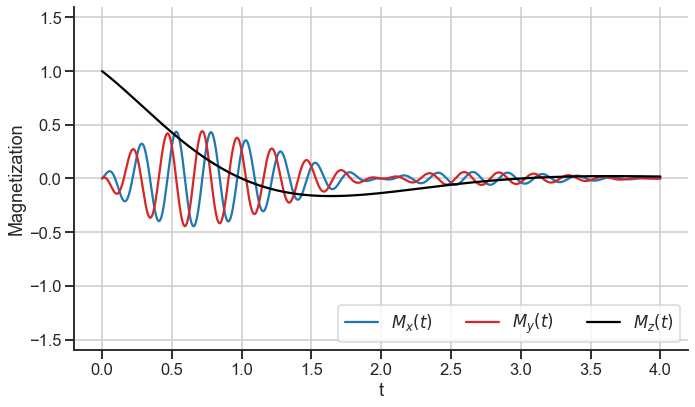

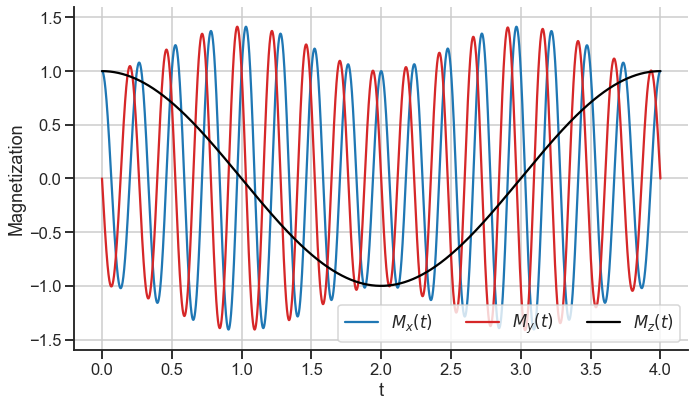

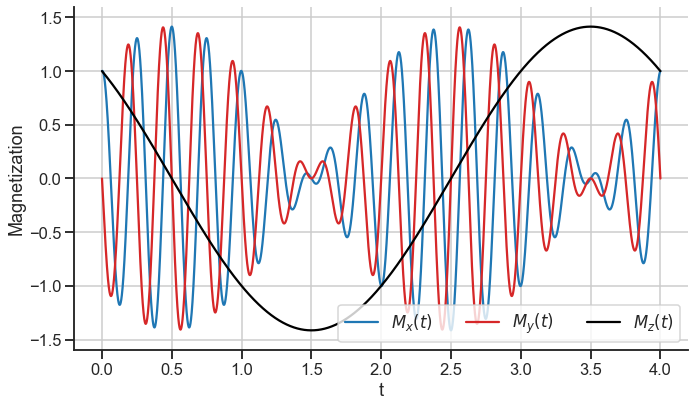

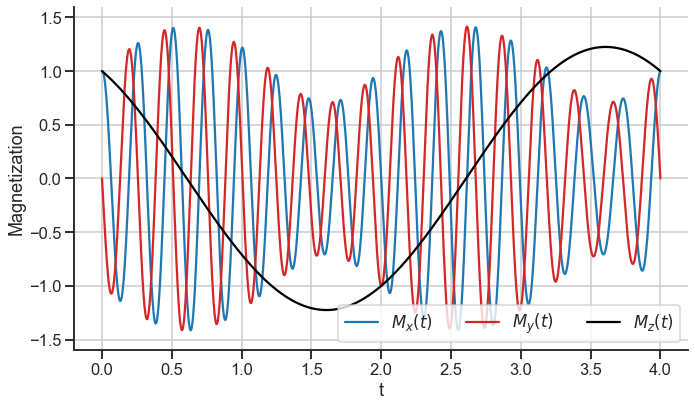

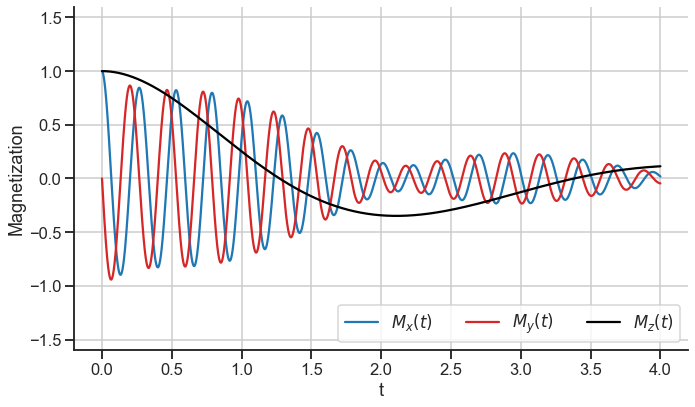

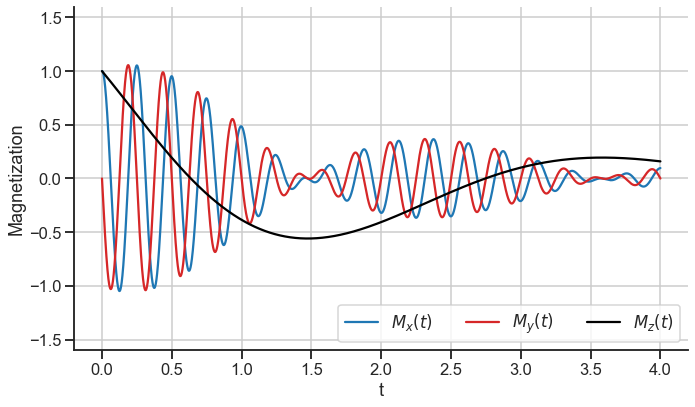

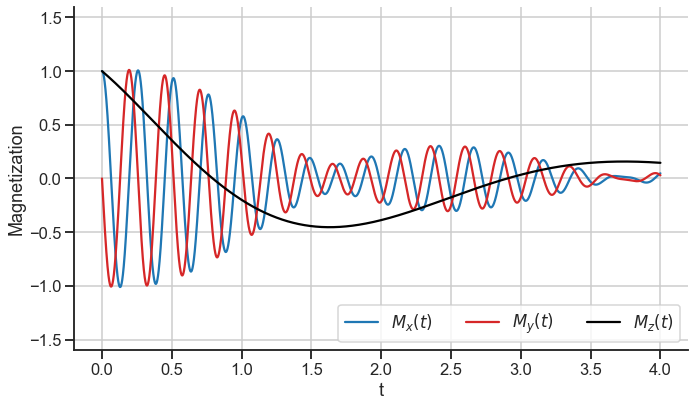

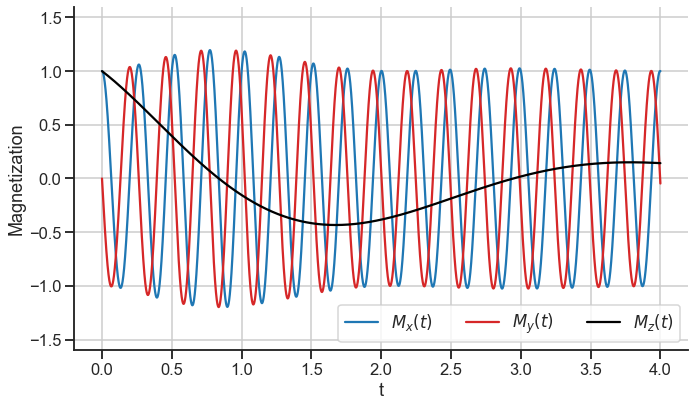

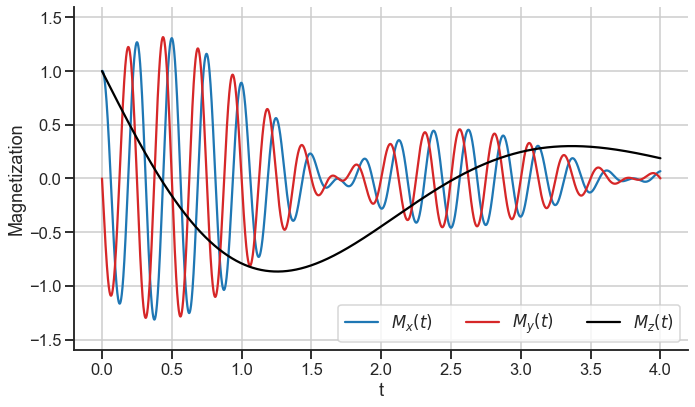

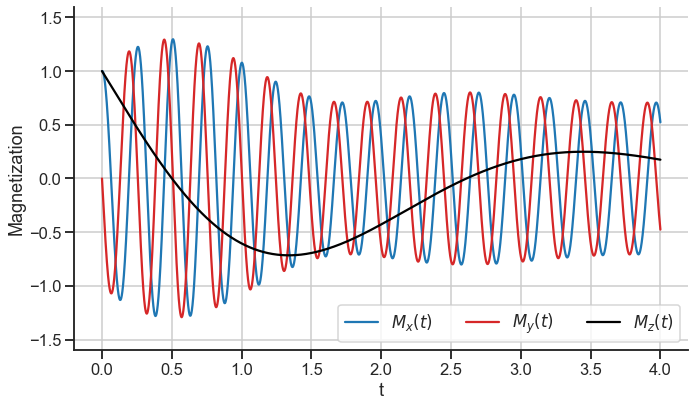

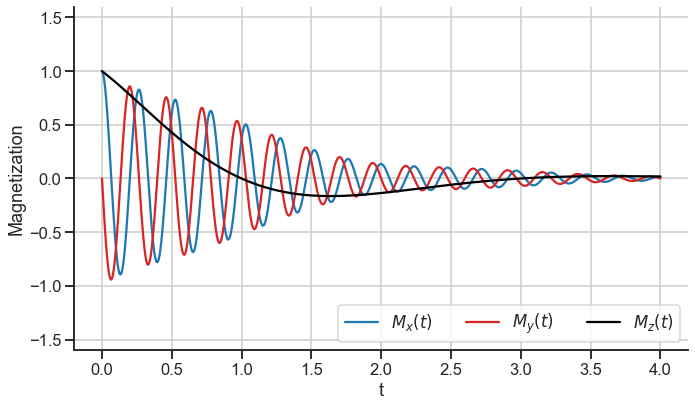

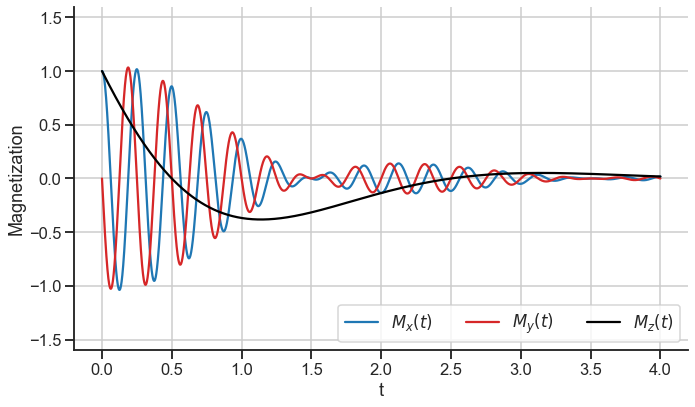

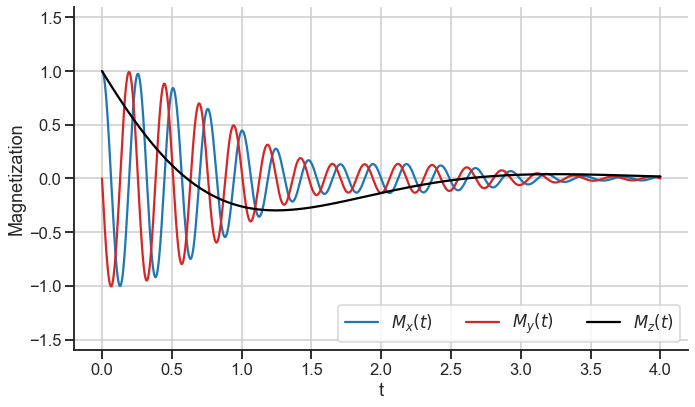

In [7]:
# Loop over all the configurations and plot the magnetization components

for M0 in M0s:
    for T1_recipr in T1_reciprs:
        for T2_recipr in T2_reciprs:
            for phi_string, phi in phis.items():
                params = params_0.copy()
                params["T1_recipr"] = T1_recipr
                params["T2_recipr"] = T2_recipr
                params["phi"] = phi

                Ms = simulate(M0, ts, params)

                fig, ax = plt.subplots(1, 1, figsize=(10, 6))

                ax.plot(ts, Ms[:, 0], label=r"$M_x(t)$", color=colors[0])
                ax.plot(ts, Ms[:, 1], label=r"$M_y(t)$", color=colors[3])
                ax.plot(ts, Ms[:, 2], label=r"$M_z(t)$", color="black")

                ax.set_ylabel("Magnetization")
                ax.set_xlabel("t")

                ax.set_yticks(np.arange(-1.5, 2, 0.5))
                ax.set_ylim(-1.6, 1.6)

                ax.legend(ncol=3, loc="lower right")
                ax.grid()

                plt.tight_layout()
                sns.despine()
                plt.savefig(f"figures/exercise_9/M0_{M0}_T1_{T1_recipr}_T2_{T2_recipr}_phi_{phi_string}.pdf")
                plt.show()